## Pablo Valdunciel Sánchez 
## 20th December, 2019

# Imports

In [3]:
import pandas as pd
import numpy as np
import keras.backend as K 
from keras import optimizers
from keras.models import Sequential 
from keras.layers import SimpleRNN, Dense, GRU, LSTM
import keras.losses, keras.optimizers

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data preparation

In [4]:
SEQ_LEN = 20 
HOLD_OUT = 0.66
X_MAX = 15 

def split_sequence(sequence, n_steps):
    X = []
    Y = []
    num_records = len(sequence) - n_steps

    for i in range(num_records):
        X.append(sequence[i:i+n_steps])
        Y.append(sequence[i+n_steps])
        
    return np.array(X),np.array(Y)

In [5]:
# Read file containing the stock values 
data = pd.read_excel('./data/historica Iberdrola DIC 16-19.xls', dtype={'Fecha': str, 'Último': float}).values 

# Reverse the data set so that mos ancient values go first 
data = np.flip(data, axis=0)

# Separate dates and stock_vales
dates = data[:,0]
stock_values = data[:,1]

# Split the sequence
X,Y = split_sequence(stock_values, SEQ_LEN)

# Scale the stock_values 
X = X / X_MAX 
Y = Y / X_MAX 

# Adjust dimensions
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=1)

# Get train and test sets (Holdout)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-HOLD_OUT), random_state=2) 

# GRU class

In [6]:
class MyGRU:
    """MyGRU class"""
    
    margin = 0.02
    
    def __init__(self, T, n_features, layer_sizes, layer_activations, 
                optimizer="adam", loss="mse", epochs=100, margin=0.02, verbose=1):
        """Initialize the network."""
        
        if len(layer_sizes) != 2: 
            raise AttributeError("layer_sizes must contain 2 elements")
            
        if len(layer_activations) != 2: 
            raise AttributeError("layer_activations must contain 2 elements")
            
        self.T = T             
        self.n_features = n_features
        self.layer_sizes = layer_sizes
        self.layer_activations = layer_activations
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss = loss
        MyGRU.margin = margin
        self.verbose = verbose       
        self.__model = None 
        self.__history = None
        
        self.__construct_model()
        print(self)
    
    
    @staticmethod
    def percentage_margin(y_true, y_pred):
        """Metric used in the training"""
        
        yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), MyGRU.margin), dtype=float))
        return yy / K.cast(K.shape(y_pred)[0], dtype=float)
    
    
    def __str__(self):
        """Provides a string representation of a MySimpleRNN instance"""
        
        return "MyGRU(T={}, n_features={}, layer_sizes={}, optimizer={}, loss={}, epochs={}, \
        margin={}, verbose={})".format(self.T, self.n_features, self.layer_sizes, self.optimizer, 
                                                        self.loss, self.epochs, MyGRU.margin, self.verbose)
    
    
    def __construct_model(self):
        """Contructs the model and compiles it"""
        
        # Create model
        self.__model = Sequential()    
        
        # Add Input layer
        input_layer = GRU(units = self.layer_sizes[0], 
                           activation = self.layer_activations[0],
                           return_sequences = False, 
                           input_shape = (self.T, self.n_features))
        self.__model.add(input_layer)
        
        
        # Add Output layer
        output_layer = Dense(units = self.layer_sizes[1],
                             activation = self.layer_activations[1])
        self.__model.add(output_layer)    
        
        # Compile model
        self.__model.compile(optimizer = self.optimizer, 
                             loss = self.loss, 
                             metrics = [MyGRU.percentage_margin])    
        self.__model.summary()
        
        
    def get_history(self):
        """Get the history of the model"""
        return self.__history 
    
    
    def fit(self, x_train, x_test, y_train, y_test):
        """Fit the model with validation data"""
        self.__history = self.__model.fit(x_train, y_train, 
                                          epochs = self.epochs, 
                                          verbose = self.verbose, 
                                          validation_data = (x_test,y_test))
    
    
    def predict(self, X):
        """Predicts the value of next element of the given sequences"""
        
        predictions = self.__model.predict(X, verbose = self.verbose)
        return predictions
                                
        
    def print_hit_rate_evolution(self):
        """Prints a lineal plot showing the evolution of the hit rates (validation an training) along the epochs"""
        
        plt.plot(self.__history.epoch, self.__history.history['val_percentage_margin'], label = 'validation')
        plt.plot(self.__history.epoch, self.__history.history['percentage_margin'], label = "training")
        plt.legend()
        plt.title('GRU')
        plt.ylabel('Hit rate')
        plt.xlabel('Epoch')
        plt.show()                                         

# Test

In [7]:
gru = MyGRU(T=SEQ_LEN, 
            n_features=1, 
            layer_sizes=[5,1], 
            layer_activations=["tanh", None], 
            epochs=150)
gru.fit(x_train, x_test, y_train, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________
MyGRU(T=20, n_features=1, layer_sizes=[5, 1], optimizer=adam, loss=mse, epochs=150,         margin=0.02, verbose=1)
Train on 475 samples, validate on 245 samples
Epoch 1/150
475/475 [==============================] - 1s 1ms/step - loss: 0.2824 - percentage_margin: 0.0000e+00 - val_loss: 0.2218 - val_percentage_margin: 0.0000e+00
Epoch 2/150
475/475 [==============================] - 0s 289us/step - loss: 0.1909 - percentage_margin: 0.0000e+00 - val_loss: 0.1438 - val_percentage_margin: 0.0000e+00
Epoch 3/150
475/

Epoch 46/150
475/475 [==============================] - 0s 342us/step - loss: 0.0017 - percentage_margin: 0.1199 - val_loss: 0.0015 - val_percentage_margin: 0.1274
Epoch 47/150
475/475 [==============================] - 0s 322us/step - loss: 0.0017 - percentage_margin: 0.1103 - val_loss: 0.0015 - val_percentage_margin: 0.1196
Epoch 48/150
475/475 [==============================] - 0s 239us/step - loss: 0.0016 - percentage_margin: 0.0998 - val_loss: 0.0015 - val_percentage_margin: 0.1235
Epoch 49/150
475/475 [==============================] - 0s 243us/step - loss: 0.0016 - percentage_margin: 0.1157 - val_loss: 0.0014 - val_percentage_margin: 0.1274
Epoch 50/150
475/475 [==============================] - 0s 236us/step - loss: 0.0016 - percentage_margin: 0.1224 - val_loss: 0.0014 - val_percentage_margin: 0.1373
Epoch 51/150
475/475 [==============================] - 0s 245us/step - loss: 0.0016 - percentage_margin: 0.1140 - val_loss: 0.0014 - val_percentage_margin: 0.1274
Epoch 52/150
475

Epoch 95/150
475/475 [==============================] - 0s 282us/step - loss: 3.7566e-04 - percentage_margin: 0.2885 - val_loss: 3.3079e-04 - val_percentage_margin: 0.2956
Epoch 96/150
475/475 [==============================] - 0s 277us/step - loss: 3.5325e-04 - percentage_margin: 0.2785 - val_loss: 3.1550e-04 - val_percentage_margin: 0.2956
Epoch 97/150
475/475 [==============================] - 0s 261us/step - loss: 3.3378e-04 - percentage_margin: 0.2978 - val_loss: 2.9575e-04 - val_percentage_margin: 0.3328
Epoch 98/150
475/475 [==============================] - 0s 273us/step - loss: 3.1629e-04 - percentage_margin: 0.3201 - val_loss: 2.8100e-04 - val_percentage_margin: 0.3229
Epoch 99/150
475/475 [==============================] - 0s 262us/step - loss: 2.9692e-04 - percentage_margin: 0.3018 - val_loss: 2.6220e-04 - val_percentage_margin: 0.3679
Epoch 100/150
475/475 [==============================] - 0s 254us/step - loss: 2.7871e-04 - percentage_margin: 0.3601 - val_loss: 2.4806e-04

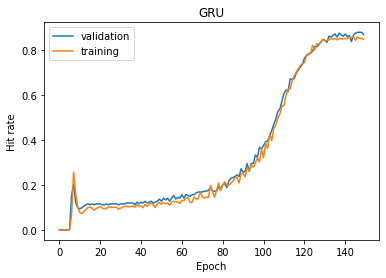

In [8]:
gru.print_hit_rate_evolution()